# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

Unlike the simple LSTM ('KF', or Kalman-filter inspired) notebooks, we won't be doing next-layer predictions, but current-layer predictions (or pixel classification scores).

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from models import build_lstm_model, build_deep_lstm_model
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Utilities

In [3]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

## Data generation

In [4]:
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [5]:
def batch_generator(num_batch, det_shape=det_shape,
                    num_seed_layers=num_seed_layers,
                    avg_bkg_tracks=avg_bkg_tracks,
                    noise_prob=noise_prob):
    """Generator of toy data batches for training"""
    shape = (num_batch,) + det_shape
    while True:
        events, sig_tracks, _ = generate_data(
            shape, num_seed_layers=num_seed_layers,
            avg_bkg_tracks=avg_bkg_tracks,
            noise_prob=noise_prob, verbose=False)
        yield (flatten_layers(events), flatten_layers(sig_tracks))

## Training

In [27]:
# Configure the model
hidden_dim = 1024
l2reg = 0. #0.001
dropout = 0. #0.2

# Configure the training
batch_size = 128
num_event = 1600000
events_per_epoch = 32000
num_epoch = num_event / events_per_epoch

In [28]:
# Build the model
model = build_deep_lstm_model(num_det_layers, det_layer_size**2,
                              l2reg=l2reg, dropout=dropout,
                              hidden_dim=hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
timedistributed_10 (TimeDistribut(None, 10, 1024)      1049600     input_4[0][0]                    
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 10, 1024)      8392704     timedistributed_10[0][0]         
____________________________________________________________________________________________________
timedistributed_11 (TimeDistribut(None, 10, 1024)      1049600     lstm_4[0][0]                     
___________________________________________________________________________________________

In [29]:
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=events_per_epoch,
                              nb_epoch=num_epoch)

Epoch 1/50
32000/32000 [==============================] - 15s - loss: 5.2215 - acc: 0.1671    
Epoch 2/50
32000/32000 [==============================] - 15s - loss: 2.3188 - acc: 0.4948    
Epoch 3/50
32000/32000 [==============================] - 15s - loss: 1.5730 - acc: 0.6086    
Epoch 4/50
32000/32000 [==============================] - 16s - loss: 1.2568 - acc: 0.6706    
Epoch 5/50
32000/32000 [==============================] - 16s - loss: 1.0688 - acc: 0.7121    
Epoch 6/50
32000/32000 [==============================] - 16s - loss: 0.9414 - acc: 0.7406    
Epoch 7/50
32000/32000 [==============================] - 16s - loss: 0.8505 - acc: 0.7629    
Epoch 8/50
32000/32000 [==============================] - 16s - loss: 0.7786 - acc: 0.7800    
Epoch 9/50
32000/32000 [==============================] - 16s - loss: 0.7192 - acc: 0.7954    
Epoch 10/50
32000/32000 [==============================] - 16s - loss: 0.6802 - acc: 0.8060    
Epoch 11/50
32000/32000 [========================

<IPython.core.display.Javascript object>


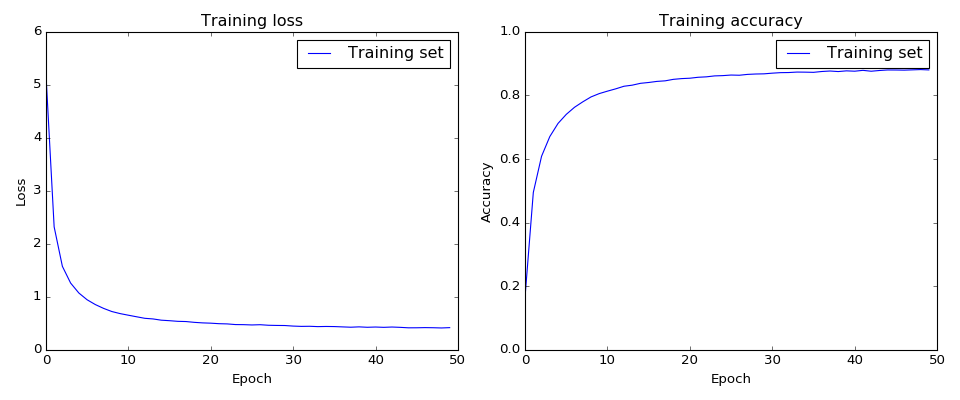

In [30]:
draw_train_history(history, draw_val=False)

## Evaluate results

In [13]:
# Generate a new test dataset
test_num_event = 51200
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_input = flatten_layers(test_events)
test_target = flatten_layers(test_sigtrks)

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB
  sig_params: 1.6384 MB


In [31]:
# Run the model on the test set
test_preds = model.predict(test_input, batch_size=batch_size)

In [32]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * flatten_layers(test_events)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.83048828125
Accuracy of classified hit:  0.924689453125


Input data example event:


<IPython.core.display.Javascript object>


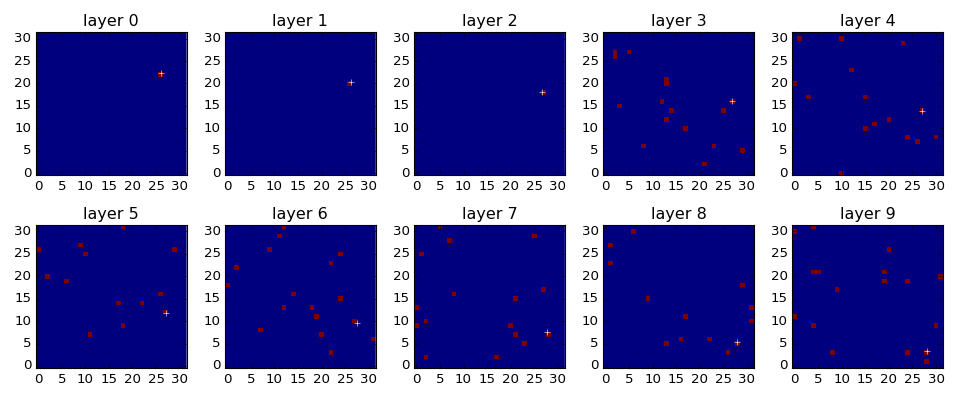

Model prediction:


<IPython.core.display.Javascript object>


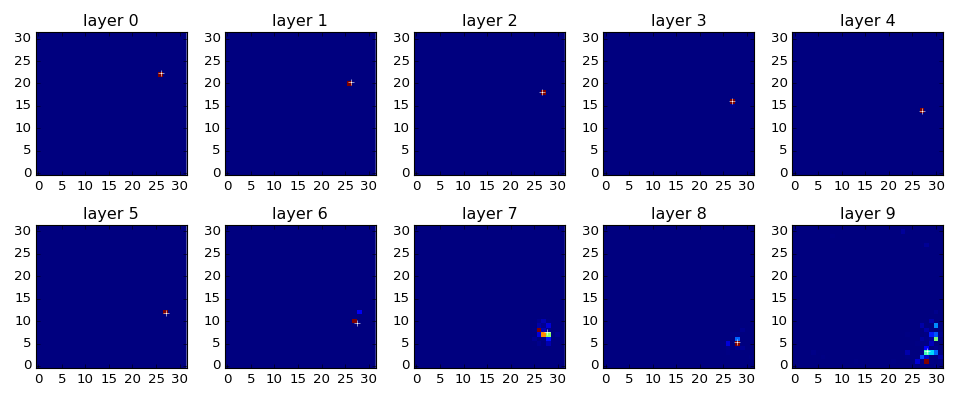

Projected input data:


<IPython.core.display.Javascript object>


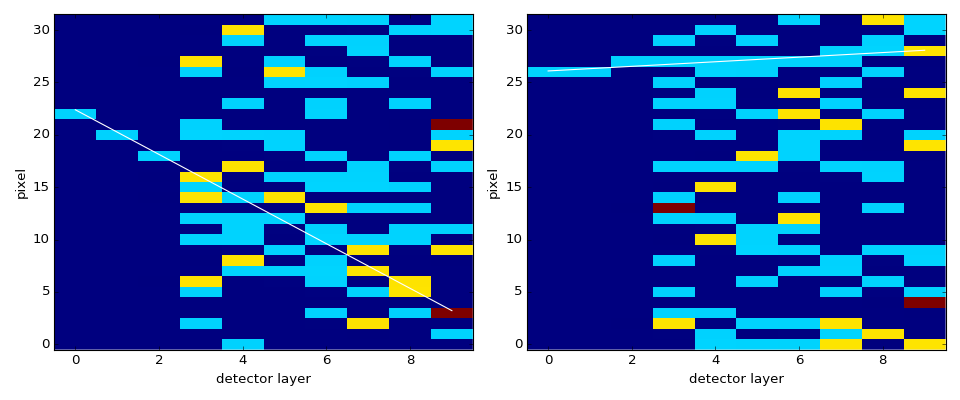

Projected model prediction:


<IPython.core.display.Javascript object>


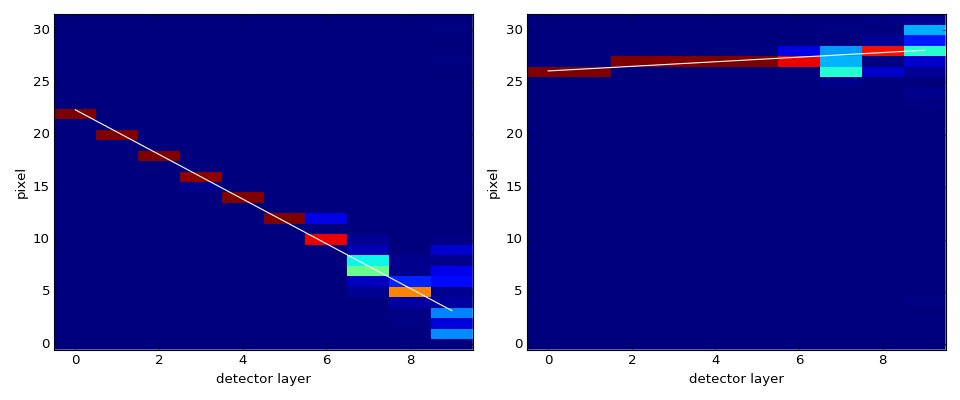

In [33]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)

## Conclusion

Utilizing current-layer predictions rather than next-layer predictions seems to work well.
In fact I see no reason to continue doing next-layer predictions despite some philosophical connection to Kalman Filter techniques.

The test set accuracy of classifying hits is >90%.

Good regularization was essential to avoid overfitting in this case.